## 安徽观测风场玫瑰图
## `Wind Rose Plot from Observation data in Anhui`

---
*@author: Evan*\
*@date: 2023-03-13*

In [42]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from functools import reduce

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [77]:
def read_wind_direction(folder_path):
    excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]

    wd_df = [pd.read_excel(os.path.join(folder_path, f), usecols=['time', '风向'], index_col='time') 
            for f in excel_files]

    merged = reduce(lambda x, y: pd.merge(x, y, on='time',how='outer'), wd_df)
    data=merged.drop_duplicates()

    new_columns = [f'site{i}' for i in range(1, len(data.columns) + 1)]
    data.columns=new_columns
    data=data.apply(pd.to_numeric, errors='coerce') #将字符串强行转换为NaN

    # 将角度转化为弧度
    rad = np.radians(data)
    # 计算x和y方向的分量
    wd_x = np.cos(rad)
    wd_y = np.sin(rad)

    # 计算每小时的平均x和y分量
    mean_wd_x = wd_x.mean(axis=1)
    mean_wd_y = wd_y.mean(axis=1)

    # 计算平均风向角度
    mean_wd_rad = np.arctan2(mean_wd_y, mean_wd_x)
    mean_wd_deg = np.degrees(mean_wd_rad)

    # 将平均风向角度添加到新的dataframe中
    mean_data = pd.DataFrame(mean_wd_deg, columns=['风向'])
    
    return mean_data

In [73]:
def read_wind_speed(folder_path):
    excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]

    dfs = {}
    for i, file in enumerate(excel_files):
        df_name = 'df' + str(i+1)
        df = pd.read_excel(os.path.join(folder_path, file))
        dfs[df_name] = df
        
    # 提取每个DataFrame对象中的“time”和数据列
    df_list = []
    for name, df in dfs.items():
        df_list.append(df[['time','风速']])

    # 使用concat函数将所有提取的“time”和数据列堆叠起来
    merged_df = pd.concat(df_list, axis=0)

    # 将列中可能存在的字符串强制转为NaN
    merged_df['风速'] = pd.to_numeric(merged_df['风速'], errors='coerce')
 
    # # 使用merge函数将所有行根据“time”列进行合并
    wind_data = merged_df.groupby('time').mean().reset_index()
    wind_data = wind_data.set_index('time')
    ws=wind_data.drop_duplicates()
    
    return wind_data

In [82]:
def wind_rose(input_df, bins, colors, title):
    '''
    使用风速风向数据绘制玫瑰图, 风向频率沿r轴表现, 风速用填色表现
    
    :param input_df: 输入风场数据Dataframe, 要求列名中包含'风速'与'风向'
    :param bins: 风速分段
    :param colors: 一维数组, 根据风速填色的颜色, shape=(bins-1,)
    :param rticklabels: 极坐标r轴坐标刻度名称
    :param title: 图的标题
    '''
    
    # 分离不同的风速阶段
    bins = [0, 1.5, 3.3, 5.4, 7.9,]# 10.7, 13.8, 17.1]
    labels = ['{}-{} m/s'.format(bins[i-1], bins[i]) for i in range(1, len(bins))]
    input_df['ws_range'] = pd.cut(input_df['风速'], bins=bins, labels=labels, include_lowest=True)

    # 测试：根据不同风速段计数，并使用index
    test_subset = input_df[(input_df['风向'] >= 80) & (input_df['风向'] < 80 + 10)]
    test=test_subset[['风速','ws_range']].groupby('ws_range').count()
    
    # 创建完整的风速分段表格
    columns=np.arange(0,360,10)
    index=test.index
    ws=pd.DataFrame(columns=columns,index=index)
    for i in range(0, 360, 10):
        subset = input_df[(input_df['风向'] >= i) & (input_df['风向'] < i + 10)]
        ws[i]=subset[['风速','ws_range']].groupby('ws_range').count()
    ws_t=ws.T
    # 将NaN设置为0
    ws_t.replace(np.nan, 0, inplace=True)

    # 绘制堆叠式极坐标图
    fig = plt.figure(figsize=(6, 6),dpi=300)
    ax = fig.add_subplot(111, projection='polar')

    # 设置角度标签
    directions = np.arange(0, 360, 10) * np.pi / 180
    direction_names = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    ax.set_xticks(np.arange(0,360,22.5)* np.pi / 180)
    ax.set_xticklabels(direction_names)

    bottom0=pd.Series(np.zeros(len(ws.columns)), index=ws.columns)
    bottom1 = ws_t.iloc[:, 0]
    bottom2 = ws_t.iloc[:, 1]+ws_t.iloc[:, 0]
    bottom3 = ws_t.iloc[:, 2]+ws_t.iloc[:, 1]+ws_t.iloc[:, 0]
    bottoms = np.vstack((bottom0, bottom1, bottom2, bottom3))
    
    for i in range(len(ws.index)):
        ax.bar(directions, ws_t.iloc[:, i], width=np.pi/180*10, bottom=bottoms[i,:], color=colors[i], alpha=0.8)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    # 添加图例
    plt.legend(ws.index,ncol=4,bbox_to_anchor=(0.5,-0.1),loc='upper center')

    # 添加标题
    plt.title(title)

    return fig

In [96]:
path_urban='D:/files/Master/02学术/横向项目_安庆/data/obs_anqing/urban/'
ws=read_wind_speed(path_urban)
wd=read_wind_direction(path_urban)
urban=pd.merge(wd,ws,how='outer',on='time')

path_channel='D:/files/Master/02学术/横向项目_安庆/data/obs_anqing/channel/'
ws=read_wind_speed(path_channel)
wd=read_wind_direction(path_channel)
channel=pd.merge(wd,ws,how='outer',on='time')

In [84]:
bins = [0, 1.5, 3.3, 5.4, 7.9,]
colors=['tab:green', 'tab:blue', 'tab:orange', 'tab:red']

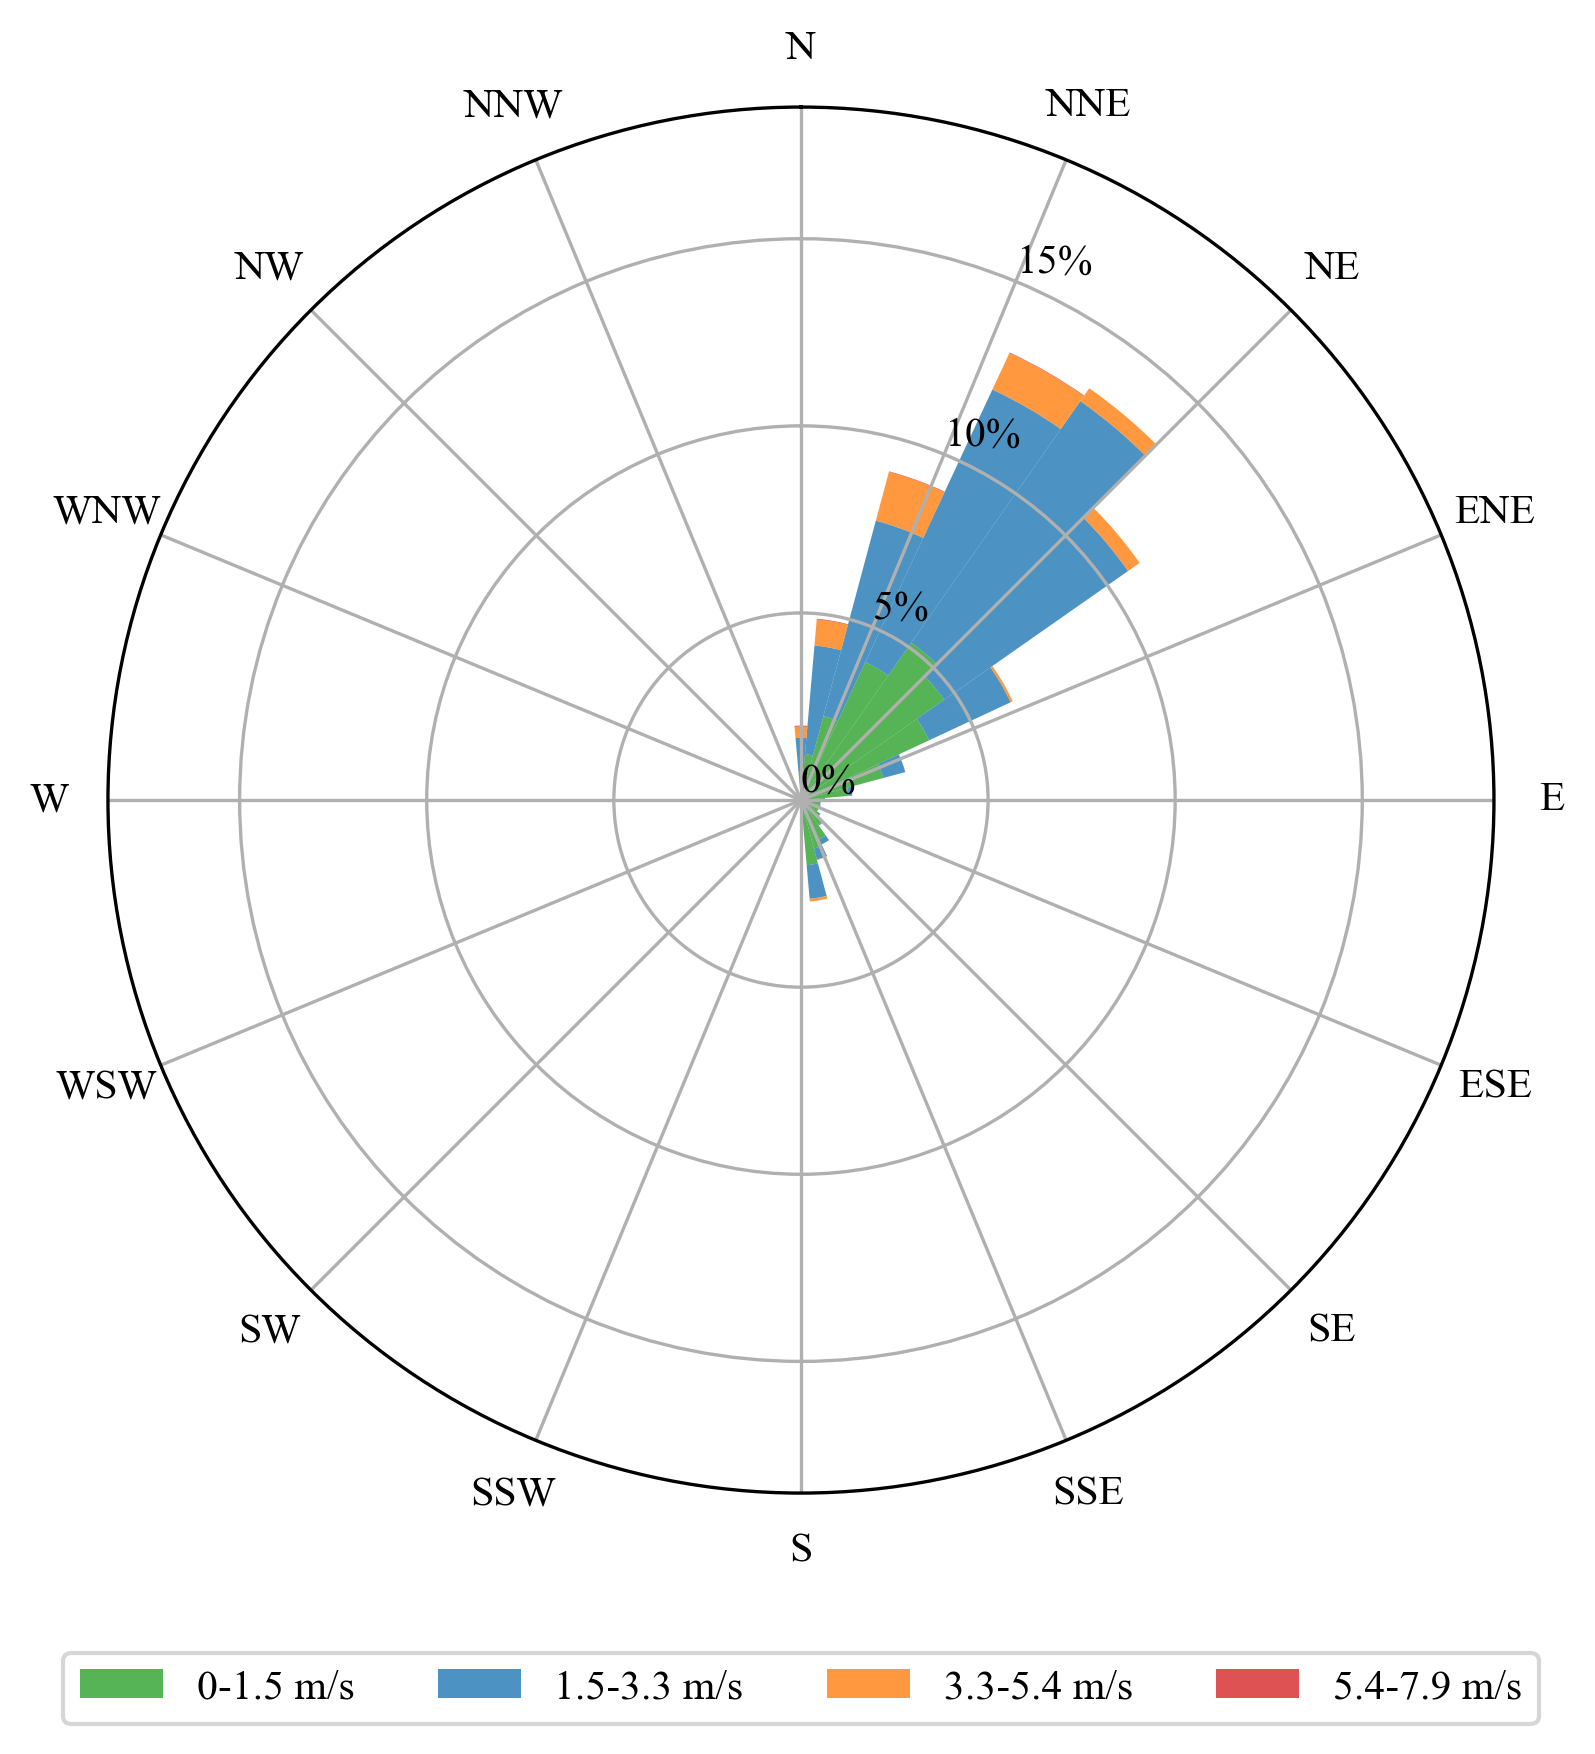

In [85]:
fig=wind_rose(urban,bins,colors,'')
ax=fig.gca()

# 设置r轴标签
ax.set_rlim(0, 5000)
ax.set_rticks(np.arange(0, 5000, 270*5)) #!风场总数为27405
ax.set_rlabel_position(22.5)
ax.set_yticklabels(['{:.0f}%'.format(x/270) for x in ax.get_yticks()])

plt.show()

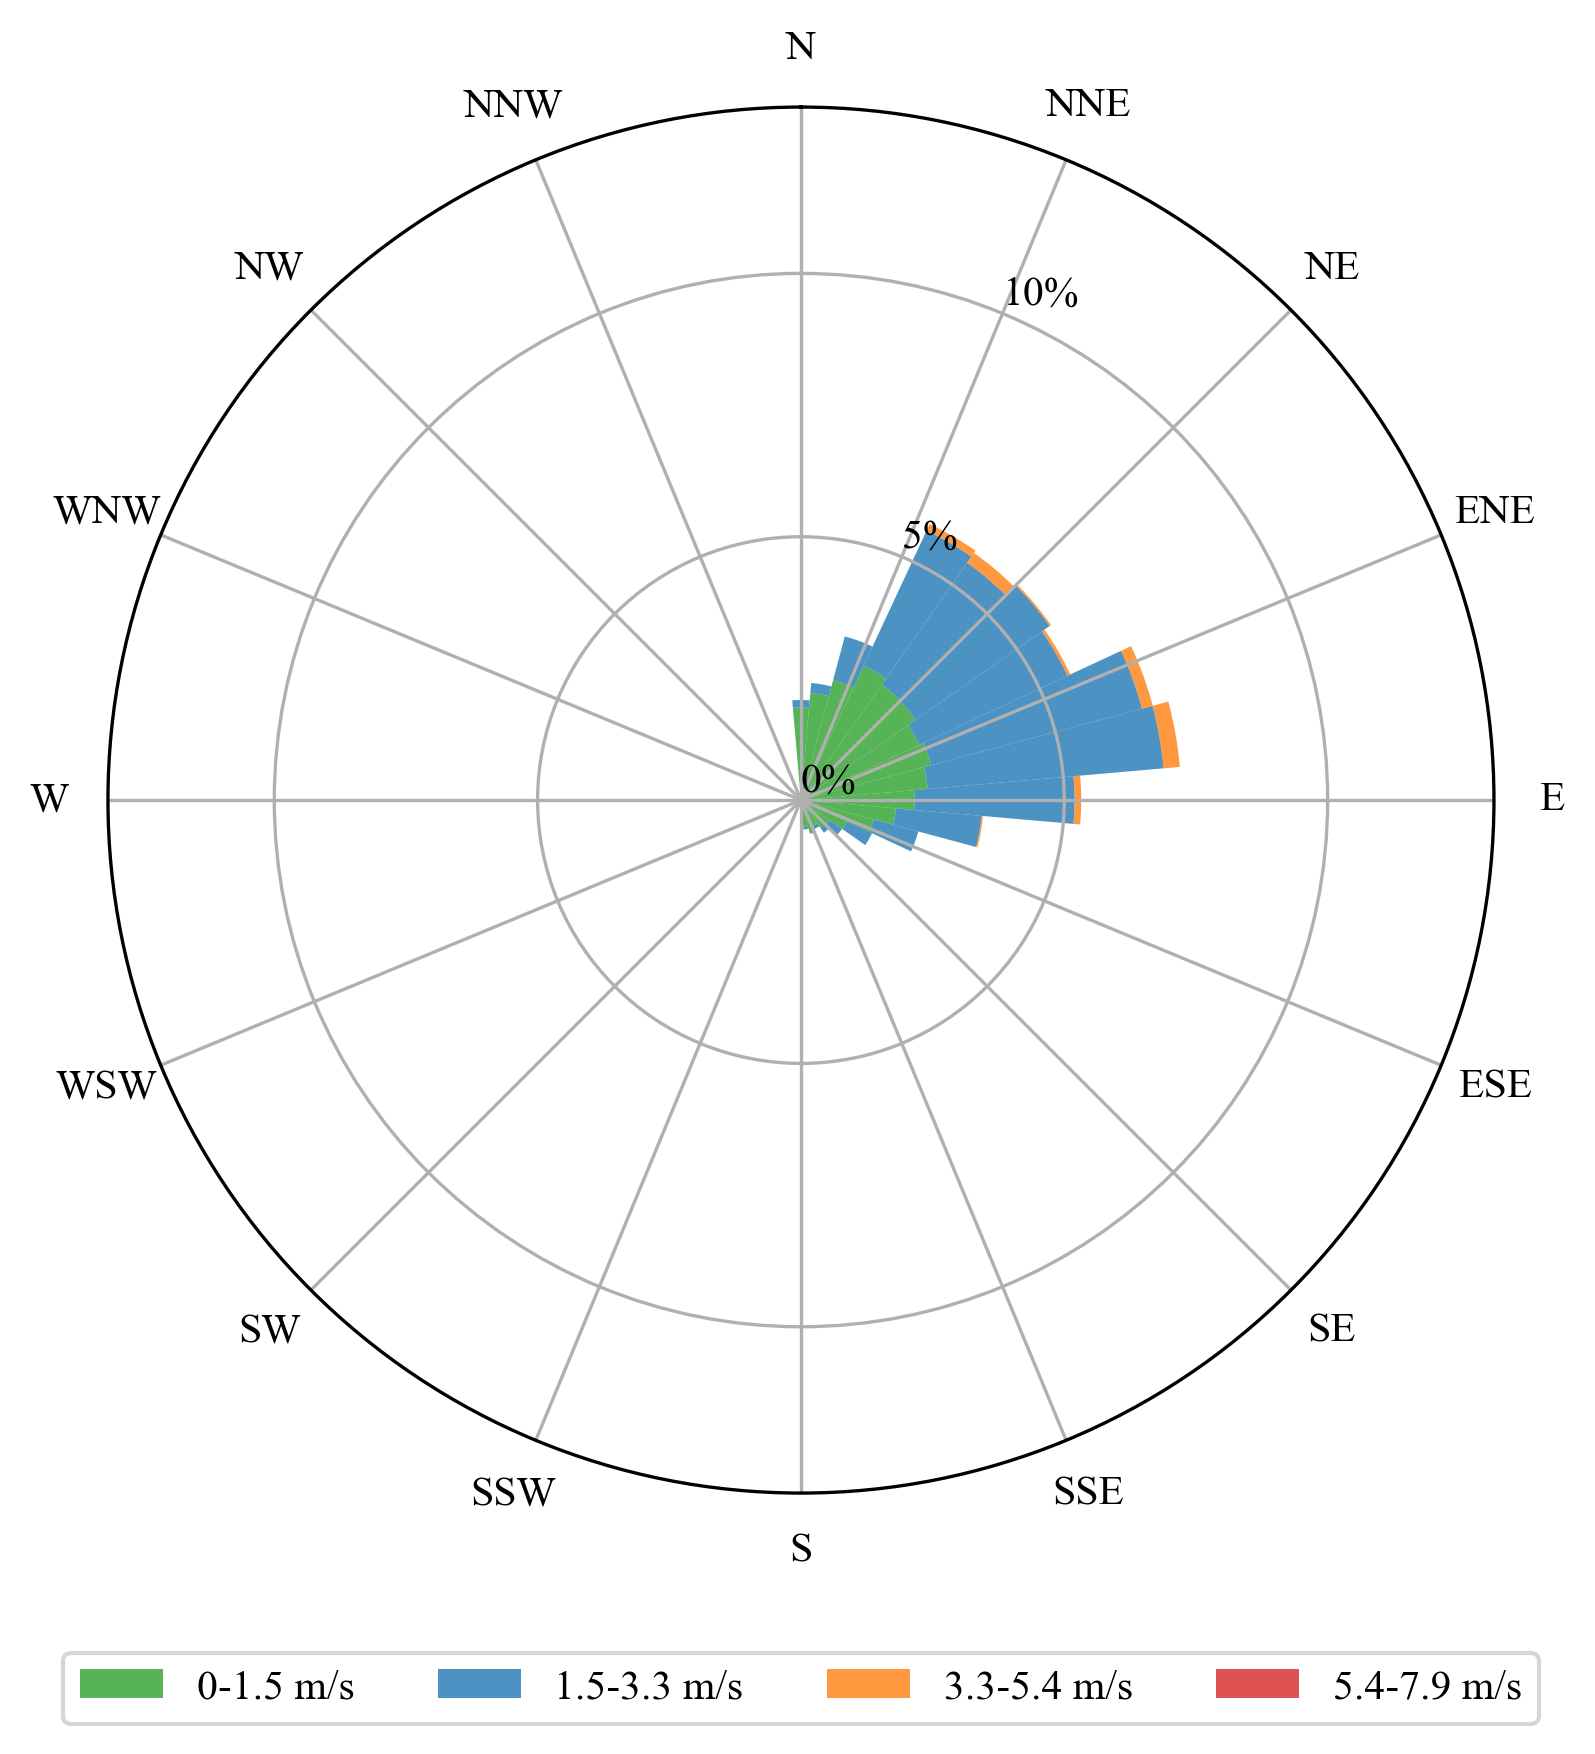

In [86]:
fig=wind_rose(channel,bins,colors,'')
ax=fig.gca()

# 设置r轴标签
ax.set_rlim(0, 2500)
ax.set_rticks(np.arange(0, 2500, 190*5)) #!风场总数为19358
ax.set_rlabel_position(22.5)
ax.set_yticklabels(['{:.0f}%'.format(x/190) for x in ax.get_yticks()])

plt.show()

In [137]:
urban_winter = pd.concat([urban['2020-01-01 00':'2020-03-01 00'], urban['2020-12-01 00':'2021-03-01 00'], 
                          urban['2021-12-01 00':'2022-03-01 00'], urban['2022-12-01 00':]],axis=0)
urban_spring= pd.concat([urban['2020-03-01 00':'2020-06-01 00'], urban['2021-03-01 00':'2021-06-01 00'], 
                          urban['2022-03-01 00':'2022-06-01 00']],axis=0)
urban_summer= pd.concat([urban['2020-06-01 00':'2020-07-28 00'], urban['2020-07-29 00':'2020-09-01 00'],
                         urban['2021-06-01 00':'2021-09-01 00'], urban['2022-06-01 00':'2022-09-01 00']],axis=0)
urban_autumn= pd.concat([urban['2020-09-01 00':'2020-12-01 00'], urban['2021-09-01 00':'2021-11-04 00'], 
                         urban['2021-11-06 00':'2021-12-01 00'], urban['2022-09-01 00':'2022-12-01 00']],axis=0)
#!莫名其妙这里在数据里2020-07-28_2020-07-29,2021-11-04_2021-11-06无法提取，目前只好跳过

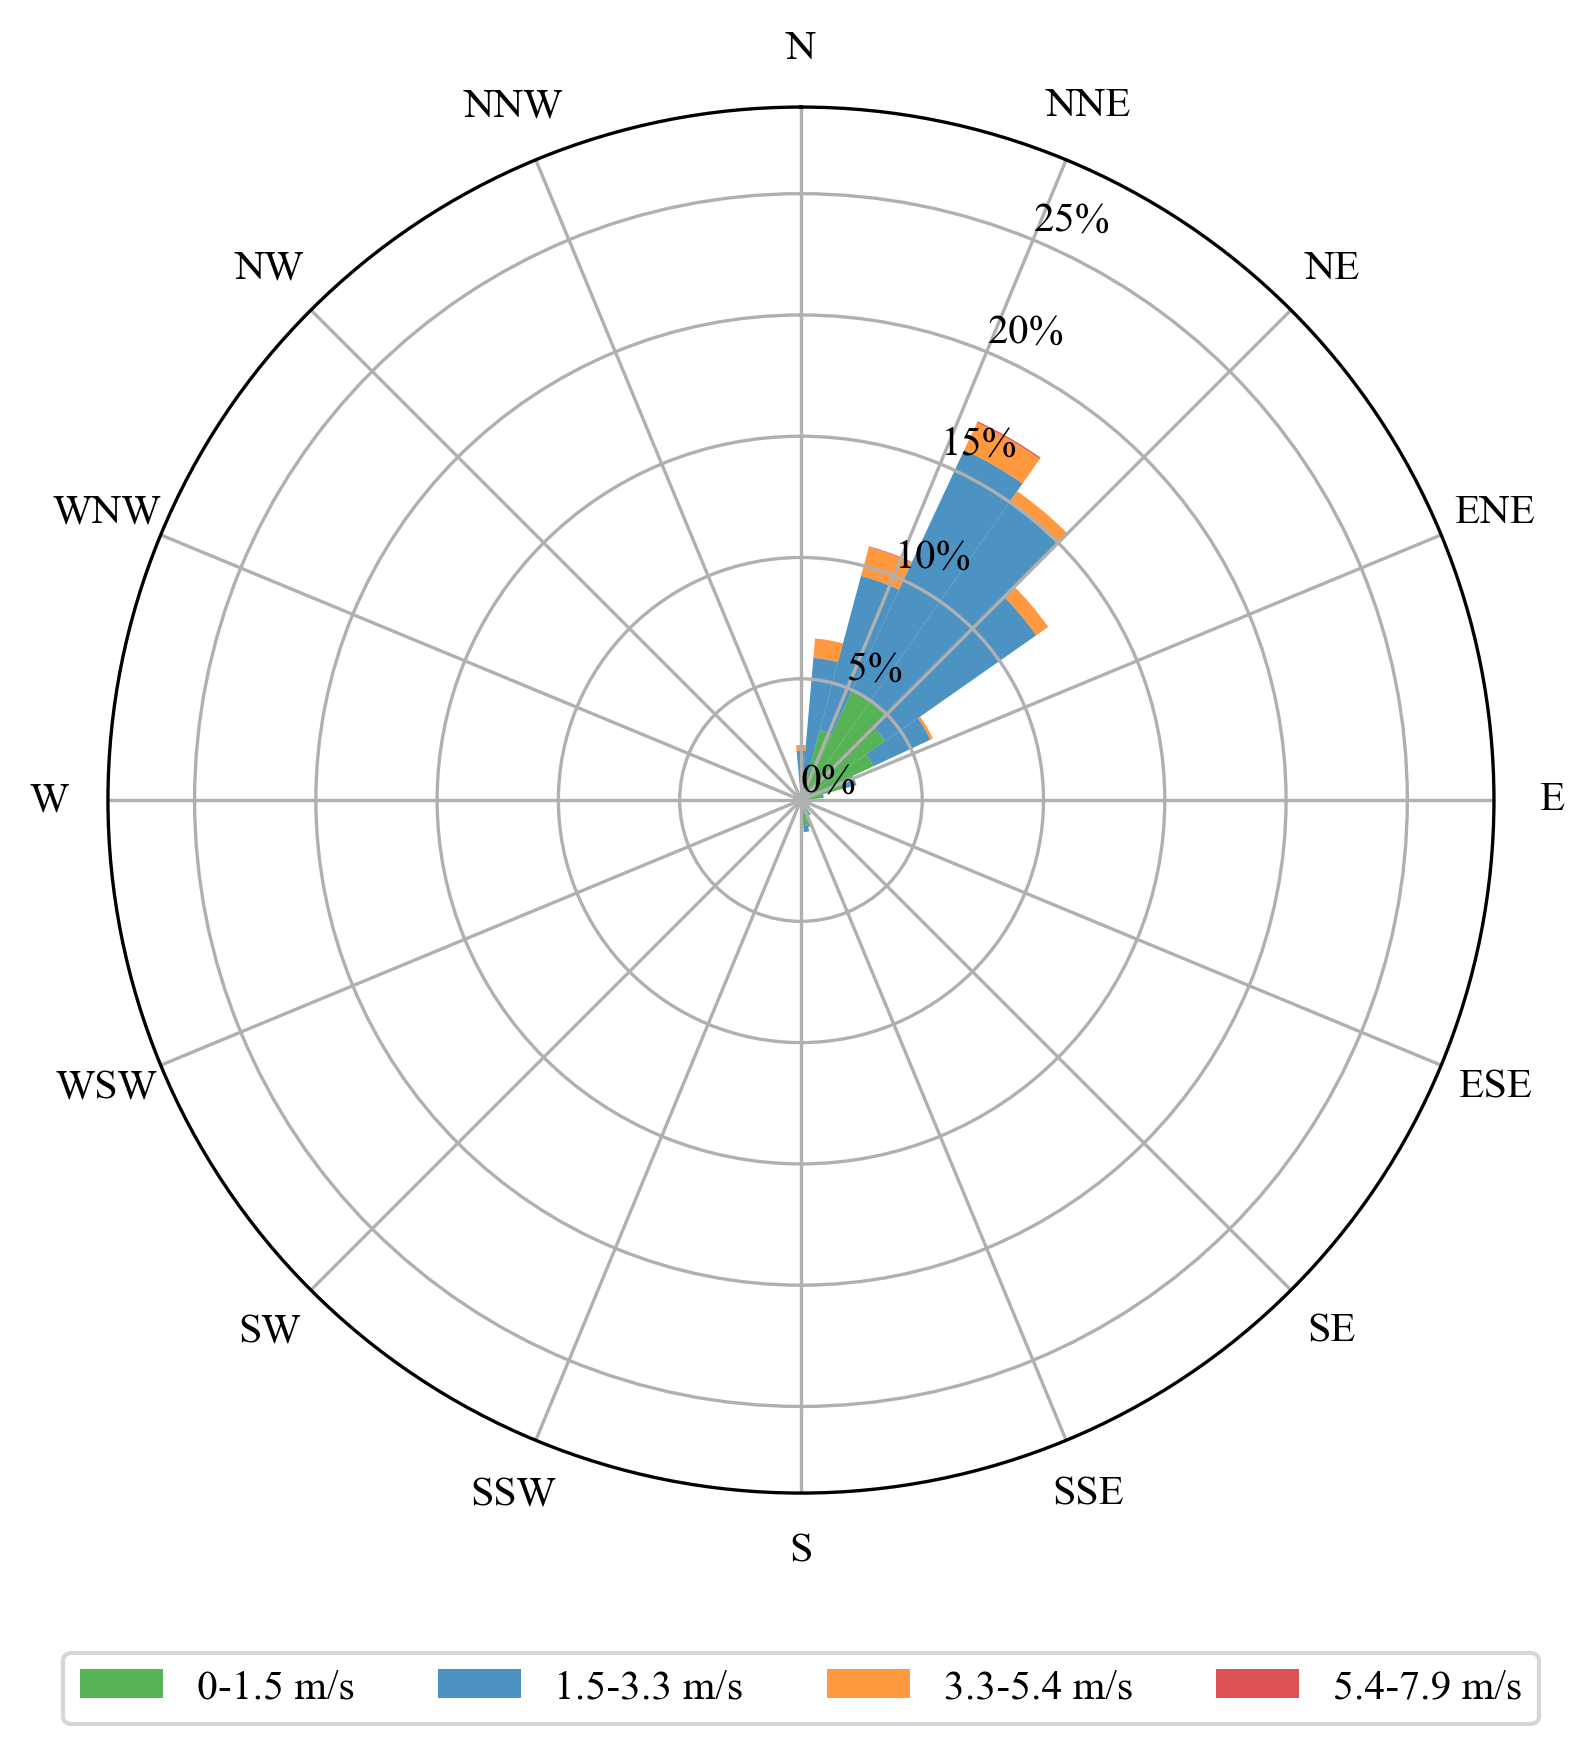

In [143]:
fig=wind_rose(urban_autumn,bins,colors,'')
ax=fig.gca()

# 设置r轴标签
ax.set_rlim(0, 2000)
ax.set_rticks(np.arange(0, 2000, 70*5))
ax.set_rlabel_position(22.5)
ax.set_yticklabels(['{:.0f}%'.format(x/70) for x in ax.get_yticks()])

plt.show()